Useful links

1. For the architecture https://towardsdatascience.com/deep-learning-for-specific-information-extraction-from-unstructured-texts-12c5b9dceada
2. https://androidkt.com/multi-label-text-classification-in-tensorflow-keras/
3. https://keras.io/preprocessing/sequence/
4. https://machinelearningmastery.com/develop-word-based-neural-language-models-python-keras/ ( Not really)
5. For deep learning using word embeddings https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/



In [1]:
import spacy
import pandas as pd
from tqdm import tqdm

In [2]:
DATA_DIR = "../../data/processed/"
INPUT_FILE_NAME = 'final_squash15_with_pos_ner.parquet'

In [3]:
df = pd.read_parquet(DATA_DIR + INPUT_FILE_NAME)
df.head()

,speaker,headline,description,duration,tags,transcript,WC,clean_transcript,clean_transcript_string,sim_tags,squash15_tags,pos_sequence,ner_sequence
0,Al Gore,Averting the climate crisis,With the same humor and humanity he exuded in ...,0:16:17,"cars,alternative energy,culture,politics,scien...","0:14\r\r\rThank you so much, Chris.\rAnd it's ...",2281.0,"b'[""thank"", ""chris"", ""truly"", ""great"", ""honor""...",thank chris truly great honor opportunity come...,"cars,solar system,energy,culture,politics,scie...","culture,politics,science,global issues,technology",NOUN PUNCT NOUN PUNCT NOUN PUNCT ADJ NOUN PUNC...,
1,Amy Smith,Simple designs to save a life,Fumes from indoor cooking fires kill more than...,0:15:06,"MacArthur grant,simplicity,industrial design,a...","0:11\r\r\rIn terms of invention,\rI'd like to ...",2687.0,"b'[""term"", ""invention"", ""like"", ""tell"", ""tale""...",term invention like tell tale favorite project...,"macarthur grant,simplicity,design,solar system...","design,global issues",NOUN PUNCT ADJ NOUN,
2,Ashraf Ghani,How to rebuild a broken state,Ashraf Ghani's passionate and powerful 10-minu...,0:18:45,"corruption,poverty,economics,investment,milita...","0:12\r\r\rA public, Dewey long ago observed,\r...",2506.0,"b'[""public"", ""dewey"", ""long"", ""ago"", ""observe""...",public dewey long ago observe constitute discu...,"corruption,inequality,science,investment,war,c...","science,culture,politics,global issues,business",NOUN PUNCT NOUN PUNCT NOUN PUNCT ADJ NOUN PUNC...,
3,Burt Rutan,The real future of space exploration,"In this passionate talk, legendary spacecraft ...",0:19:37,"aircraft,flight,industrial design,NASA,rocket ...","0:11\r\r\rI want to start off by saying, Houst...",3092.0,"b'[""want"", ""start"", ""say"", ""houston"", ""problem...",want start say houston problem enter second ge...,"flight,design,nasa,science,invention,entrepren...","design,science,business",NOUN PUNCT NOUN PUNCT NOUN,
4,Chris Bangle,Great cars are great art,American designer Chris Bangle explains his ph...,0:20:04,"cars,industrial design,transportation,inventio...","0:12\r\r\rWhat I want to talk about is, as bac...",3781.0,"b'[""want"", ""talk"", ""background"", ""idea"", ""car""...",want talk background idea car art actually mea...,"cars,design,transportation,invention,technolog...","design,technology,business,science",NOUN PUNCT NOUN PUNCT NOUN PUNCT NOUN,


In [4]:
df.iloc[:,:14].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2313 entries, 0 to 2312
Data columns (total 13 columns):
speaker                    2313 non-null object
headline                   2313 non-null object
description                2313 non-null object
duration                   2313 non-null object
tags                       2313 non-null object
transcript                 2313 non-null object
WC                         2313 non-null float64
clean_transcript           2313 non-null object
clean_transcript_string    2313 non-null object
sim_tags                   2313 non-null object
squash15_tags              2313 non-null object
pos_sequence               2313 non-null object
ner_sequence               2313 non-null object
dtypes: float64(1), object(12)
memory usage: 235.0+ KB


In [5]:
def print_full_dataframe(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def compute_tag_ratio(target_column, df=df):
    tags = df[target_column].str.replace(', ',',').str.lower().str.strip()
    split_tags = tags.str.split(',')
    tag_counts_per_talk = split_tags.apply(len)

    joined_tags = tags.str.cat(sep=',').split(',')
    all_tags = pd.Series(joined_tags)

    tag_counts = all_tags.value_counts().rename_axis(target_column).reset_index(name='counts')
    tag_counts['no_count'] = len(df)-tag_counts['counts']
    tag_counts['ratio'] = tag_counts['counts']/tag_counts['no_count']
    tag_counts['overall_ratio'] = tag_counts['counts']/(tag_counts['no_count'] + tag_counts['counts'])
    return tag_counts

#print(compute_tag_ratio('squash3_tags', df))
squashed_tag_counts = compute_tag_ratio('squash15_tags', df)
print_full_dataframe(squashed_tag_counts)

    squash15_tags  counts  no_count     ratio  overall_ratio
0         science    1467       846  1.734043       0.634241
1         culture    1155      1158  0.997409       0.499351
2      technology     787      1526  0.515727       0.340251
3   global issues     679      1634  0.415545       0.293558
4          design     477      1836  0.259804       0.206226
5         history     385      1928  0.199689       0.166450
6        business     349      1964  0.177699       0.150886
7   entertainment     285      2028  0.140533       0.123217
8           media     279      2034  0.137168       0.120623
9    biomechanics     220      2093  0.105112       0.095115
10   biodiversity     218      2095  0.104057       0.094250
11         future     218      2095  0.104057       0.094250
12       humanity     217      2096  0.103531       0.093818
13       politics     199      2114  0.094134       0.086035
14  communication     185      2128  0.086936       0.079983


# 3. Feature Extraction via Deep learning

## 3.1 Create one hot encoding

In [ ]:
# from sklearn.preprocessing import MultiLabelBinarizer

# y = []
# for index, row in df.iterrows():
#     y.append(set(row['squash3_tags'].split(',')))
    
# mlb = MultiLabelBinarizer()
# encoded_y = mlb.fit_transform(y)

In [ ]:
# print(encoded_y[0])
# print(len(encoded_y[0]))

In [6]:
joined_tags = df['squash15_tags'].str.cat(sep=',').split(',')
all_tags = pd.Series(joined_tags).str.strip().str.lower()
all_tags = list(dict.fromkeys(all_tags))
try:
    all_tags.remove('')
except:
    pass
print(all_tags)
print(len(all_tags))

['culture', 'politics', 'science', 'global issues', 'technology', 'design', 'business', 'biomechanics', 'biodiversity', 'media', 'entertainment', 'history', 'future', 'communication', 'humanity']
15


In [9]:
def create_one_hot_encode(df=df):
    complete_transcripts_tags = []
    for rows, value in df.iterrows():
        one_hot_encoding = [0] * len(all_tags)
        headline = [value['headline']]
        transcript = [value['clean_transcript_string']]
        pos_sequence = [value['pos_sequence']]
        ner_sequence = [value['ner_sequence']]
        indiv_tags = value['squash15_tags'].split(',')
        for tags in indiv_tags:
            if tags == '':
                continue
            index = all_tags.index(tags.lower().lstrip(' '))
            one_hot_encoding[index] = 1
        indiv_transcript_tags = headline + transcript + pos_sequence + ner_sequence + one_hot_encoding
        complete_transcripts_tags.append(indiv_transcript_tags)
    return pd.DataFrame(complete_transcripts_tags, columns=['headline', 'transcript', 'pos_sequence', 'ner_sequence'] + all_tags)

In [10]:
df = create_one_hot_encode()
df

,headline,transcript,pos_sequence,ner_sequence,culture,politics,science,global issues,technology,design,business,biomechanics,biodiversity,media,entertainment,history,future,communication,humanity
0,Averting the climate crisis,thank chris truly great honor opportunity come...,NOUN PUNCT NOUN PUNCT NOUN PUNCT ADJ NOUN PUNC...,,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1,Simple designs to save a life,term invention like tell tale favorite project...,NOUN PUNCT ADJ NOUN,,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,How to rebuild a broken state,public dewey long ago observe constitute discu...,NOUN PUNCT NOUN PUNCT NOUN PUNCT ADJ NOUN PUNC...,,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0
3,The real future of space exploration,want start say houston problem enter second ge...,NOUN PUNCT NOUN PUNCT NOUN,,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
4,Great cars are great art,want talk background idea car art actually mea...,NOUN PUNCT NOUN PUNCT NOUN PUNCT NOUN,,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0
5,Sampling the ocean's DNA,break ask people comment age debate comment un...,NOUN PUNCT NOUN PUNCT NOUN PUNCT NOUN,ORG,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0
6,Simplicity sells,music sound silence simon garfunkel hello voic...,NOUN PUNCT NOUN PUNCT NOUN PUNCT NOUN PUNCT NOUN,,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0
7,A memorial at Ground Zero,kurt andersen like architect david hog limelig...,NOUN PUNCT NOUN,,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,To invent is to give,point time come learn morning world expert gue...,NOUN PUNCT NOUN PUNCT NOUN PUNCT NOUN PUNCT NO...,,1,0,1,1,1,1,1,0,0,1,0,0,0,0,0
9,The killer American diet that's sweeping the p...,legitimate concern aid avian flu hear brillian...,NOUN PUNCT NOUN PUNCT ADJ NOUN,,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [11]:
def get_target_column(target_tag, df=df):
    return df[['headline', 'transcript','pos_sequence', 'ner_sequence', target_tag]]
single_class = get_target_column('culture', df)

In [12]:
# df_x = single_class[['transcript']]
# df_y = df[['technology']]

In [13]:
df_x = single_class[['headline', 'transcript','pos_sequence', 'ner_sequence']]
df_y = list(single_class['culture'])
#print(df_x[0])

## 3.2 Perform train test split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, train_y, valid_y = train_test_split(df_x, df_y)

In [15]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Conv1D, MaxPooling1D, concatenate
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras import optimizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import numpy as np

Using TensorFlow backend.


## 3.3 Use word embeddings for the main transcript

In [16]:
# Extract train and test transcripts to list 
X_train_transcripts = X_train['transcript'].tolist()
X_test_transcripts = X_test['transcript'].tolist()
# Extract headline - we will use tfidf because headlines are short 
X_train_headline = X_train['headline'].tolist()
X_test_headline = X_test['headline'].tolist()
# Extract POS tags
X_train_pos_seq= X_train['pos_sequence'].tolist()
X_test_pos_seq = X_test['pos_sequence'].tolist()
# Extract NER tags
X_train_ner_seq = X_train['ner_sequence'].tolist()
X_test_ner_seq = X_test['ner_sequence'].tolist()

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_transcripts)

X_train_transcripts = tokenizer.texts_to_sequences(X_train_transcripts)
X_test_transcripts = tokenizer.texts_to_sequences(X_test_transcripts)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 500 # since the average length is about there. Too long and the predicions are bad. we assume the intro has the most info

X_train_transcripts = pad_sequences(X_train_transcripts, padding='post', maxlen=maxlen)
X_test_transcripts = pad_sequences(X_test_transcripts, padding='post', maxlen=maxlen)

In [19]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [20]:
print(X_train_transcripts[1])
print(X_train_transcripts.shape)
print(type(X_train_transcripts))

[ 192  373 2030 1881 1930 2074 1101   13 4396  262   30    1  742  430
 2089  488  208  314   57  313   24   13    4  373 2911   57  603 3144
 1847  263    1    9 1089  145 3214    9 1847 1179  263   67 2467   29
 2117   72    4  105  285  263  215  438  260  157    6   33 4312 2467
  263  215   33  946  171  263  215   98  241   39  791   30   20   18
  157    6  742  142   30 4312 1880    6    5  398  108    5  499  108
  373  263  108 2823   17  488    4 3144   19    6    9 1272 3174    9
   92  960   57   99 3454  239  260   84   84    3  171  263  215  231
  111  124    6    6 1882    5  413  304  205    8    7   82  714  441
 1096   12   54  373 2610  354  120  287   85  428    3  209  192  108
  304    4  275   46  263  121    3    4    2  275   83  121  304  263
  121    4  263  121 1585    5    3    5  270    4    4   15  275    3
  263  121   15    3 2485  263  121  734   21  121 1444    8  304   36
 1114   15   59  104 1096 4397  263  121    6   54  373  275  276   15
    5 

In [21]:
print(train_y[0])

0


## 3.4 tfidf the headline

In [ ]:
# tfidf_vect_pos = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=50)
# tfidf_vect_pos.fit(X_train_headline)

# xtrain_tfidf_headline =  tfidf_vect_pos.transform(X_train_headline)
# xtest_tfidf_headline =  tfidf_vect_pos.transform(X_test_headline)


In [ ]:
# print(xtrain_tfidf_headline.shape)
# print(xtest_tfidf_headline.shape)
# print(xtrain_tfidf_headline[0])
# print(type(xtrain_tfidf_headline))

In [ ]:
# tfidf_vect_pos = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
# tfidf_vect_pos.fit(df['pos_sequence'])
# tfidf_vect_ner = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
# tfidf_vect_ner.fit(df['ner_sequence'])

# xtrain_tfidf_pos =  tfidf_vect_pos.transform(X_train['pos_sequence'])
# xtest_tfidf_pos =  tfidf_vect_pos.transform(X_test['pos_sequence'])

# xtrain_tfidf_ner =  tfidf_vect_ner.transform(X_train['ner_sequence'])
# xtest_tfidf_ner =  tfidf_vect_ner.transform(X_test['ner_sequence'])

In [22]:
# Try word embeddings on the vector 
tokenizer2 = Tokenizer(num_words=100)
tokenizer2.fit_on_texts(X_train_headline)

X_train_headline = tokenizer.texts_to_sequences(X_train_headline)
X_test_headline = tokenizer.texts_to_sequences(X_test_headline)

vocab_size2 = len(tokenizer2.word_index) + 1

maxlen2 = 100 # since the average length is about there. Too long and the predicions are bad. we assume the intro has the most info

X_train_headline = pad_sequences(X_train_headline, padding='post', maxlen=maxlen2)
X_test_headline = pad_sequences(X_test_headline, padding='post', maxlen=maxlen2)

# Model

In [23]:
from keras.utils import plot_model
# define two sets of inputs
inputA = Input(shape=(maxlen2,))
inputB = Input(shape=(maxlen,))
 
# the first branch operates on the first input which is the headline
embedding_layer_hedline = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inputA) 
#model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
#model.add(layers.Conv1D(128, 5, activation='relu'))
x = Conv1D(128, 5, activation='relu')(embedding_layer_hedline)
# model.add(layers.GlobalMaxPooling1D())
x = GlobalMaxPooling1D()(x)
x = Dense(10, activation='relu')(x)
X = Dropout(0.2)(x)
x = Dense(4, activation="relu")(x)
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

# x = Dense(50, activation="relu")(inputA)
# x = Dense(4, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
 
# the second branch opreates on the second input
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inputB)
y = LSTM(128)(embedding_layer)
y = Dropout(0.2)(y)
y = Dense(4, activation='relu')(y)
y = Model(inputs=inputB, outputs=y)
 
# combine the output of the two branches
combined = concatenate([x.output, y.output])
 
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="sigmoid")(z)
 
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)
print(model.summary())
adam = optimizers.adam(lr=0.0001)
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     4280100     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)    

In [24]:
adam = optimizers.adam(lr=0.001)
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
history = model.fit([X_train_headline, X_train_transcripts], train_y, batch_size=32, epochs=4, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1387 samples, validate on 347 samples
Epoch 1/4
1387/1387 [==============================] - ETA: 2:03 - loss: 0.7091 - acc: 0.437 - ETA: 1:10 - loss: 0.6921 - acc: 0.531 - ETA: 52s - loss: 0.6881 - acc: 0.531 - ETA: 46s - loss: 0.7027 - acc: 0.47 - ETA: 40s - loss: 0.7010 - acc: 0.48 - ETA: 36s - loss: 0.7011 - acc: 0.48 - ETA: 33s - loss: 0.7058 - acc: 0.48 - ETA: 29s - loss: 0.7045 - acc: 0.48 - ETA: 27s - loss: 0.7029 - acc: 0.49 - ETA: 25s - loss: 0.7028 - acc: 0.48 - ETA: 24s - loss: 0.7022 - acc: 0.47 - ETA: 22s - loss: 0.7014 - acc: 0.46 - ETA: 21s - loss: 0.7008 - acc: 0.47 - ETA: 20s - loss: 0.7001 - acc: 0.48 - ETA: 18s - loss: 0.6995 - acc: 0.49 - ETA: 17s - loss: 0.6991 - acc: 0.50 - ETA: 16s - loss: 0.6988 - acc: 0.49 - ETA: 15s - loss: 0.6985 - acc: 0.49 - ETA: 14s - loss: 0.6982 - acc: 0.50 - ETA: 13s - loss: 0.6980 - acc: 0.49 - ETA: 13

In [ ]:
# from keras.utils import plot_model
# # define two sets of inputs
# inputA = Input(shape=(50,))
# inputB = Input(shape=(maxlen,))
 
# # the first branch operates on the first input
# x = Dense(50, activation="relu")(inputA)
# x = Dense(4, activation="relu")(x)
# x = Model(inputs=inputA, outputs=x)
 
# # the second branch opreates on the second input
# embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inputB)
# y = LSTM(128)(embedding_layer)
# y = Dense(4, activation='sigmoid')(y)
# y = Model(inputs=inputB, outputs=y)
 
# # combine the output of the two branches
# combined = concatenate([x.output, y.output])
 
# # apply a FC layer and then a regression prediction on the
# # combined outputs
# z = Dense(2, activation="relu")(combined)
# z = Dense(1, activation="linear")(z)
 
# # our model will accept the inputs of the two branches and
# # then output a single value
# model = Model(inputs=[x.input, y.input], outputs=z)
# print(model.summary())
# adam = optimizers.adam(lr=0.0001)
# #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])

In [25]:
plot_model(model, to_file='model_plot_cnn.png', show_shapes=True, show_layer_names=True)

In [ ]:
# adam = optimizers.adam(lr=0.0001)
# #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
# history = model.fit([xtrain_tfidf_headline, X_train_transcripts], train_y, batch_size=32, epochs=4, verbose=1, validation_split=0.2)

In [ ]:
# from keras.utils import plot_model
# plot_model(model)

In [ ]:
# deep_inputs = Input(shape=(maxlen,))
# embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
# LSTM_Layer_1 = LSTM(128)(embedding_layer)
# dense_layer_1 = Dense(1, activation='sigmoid')(LSTM_Layer_1)
# model = Model(inputs=deep_inputs, outputs=dense_layer_1)

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# history = model.fit(X_train, train_y, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [ ]:
# model_glove = Sequential()
# model_glove.add(Embedding(vocab_size, 100, input_length=3000, weights=[embedding_matrix], trainable=False))(Input(shape=(maxlen,)))
# model_glove.add(Dropout(0.2))
# model_glove.add(Conv1D(64, 5, activation='relu'))
# model_glove.add(MaxPooling1D(pool_size=4))
# model_glove.add(LSTM(100))
# model_glove.add(Dense(1, activation='sigmoid'))
# model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# ## Fit train data
# model_glove.fit(X_train, np.array(train_y), validation_split=0.2, epochs = 3)

In [26]:
predictions = model.predict([X_test_headline, X_test_transcripts])

In [27]:
print(predictions)

[[0.4926391 ]
 [0.49119186]
 [0.42798203]
 [0.5019249 ]
 [0.47338685]
 [0.44056973]
 [0.49054223]
 [0.477354  ]
 [0.5019249 ]
 [0.5019249 ]
 [0.44363528]
 [0.46968332]
 [0.4528532 ]
 [0.5019249 ]
 [0.5019249 ]
 [0.5019249 ]
 [0.5019249 ]
 [0.49779418]
 [0.5019249 ]
 [0.43591228]
 [0.46477976]
 [0.484856  ]
 [0.4423359 ]
 [0.44940698]
 [0.5019249 ]
 [0.5019249 ]
 [0.5019249 ]
 [0.43684918]
 [0.5019249 ]
 [0.47135043]
 [0.4660691 ]
 [0.44383097]
 [0.5019249 ]
 [0.4153207 ]
 [0.4551535 ]
 [0.44113097]
 [0.481593  ]
 [0.42015517]
 [0.44666576]
 [0.41912547]
 [0.50149244]
 [0.4482191 ]
 [0.4549734 ]
 [0.4725551 ]
 [0.4363911 ]
 [0.42813212]
 [0.41834447]
 [0.49779418]
 [0.49779418]
 [0.5019249 ]
 [0.5019249 ]
 [0.49854097]
 [0.475648  ]
 [0.41205314]
 [0.46700692]
 [0.49181917]
 [0.49779418]
 [0.5019249 ]
 [0.5019249 ]
 [0.5019249 ]
 [0.44444004]
 [0.41593033]
 [0.47907704]
 [0.49206373]
 [0.48122823]
 [0.45443347]
 [0.4142836 ]
 [0.4364682 ]
 [0.45750642]
 [0.4823123 ]
 [0.5019249 ]
 [0.43

In [28]:
def get_tag(threshold, predictions=predictions):
    return [[1 if j > threshold else 0 for j in i.tolist()] for i in predictions]

def get_tag_flat(threshold, predictions=predictions):
    return [1 if j > threshold else 0 for i in predictions for j in i]
predictions_flushed = get_tag(0.4)


In [29]:
def compute_tp_tn_fp_fn(y_test, y_pred, classes):
    '''
    Return:
    pre_score = {
        'tag_1': {
            'index': ,
            'tp': ,
            'tn': ,
            'fp': ,
            'fn': 
        }
    }
    '''
    # Create dictionary of tags 
    pre_score = {}
    for index_tag, tag in enumerate(classes):
        pre_score[tag] = {
            'index':index_tag,
            'tp': 0,
            'tn': 0,
            'fp': 0,
            'fn': 0
        }
    for transcript_index, transcript_value in enumerate(y_test):
        if transcript_value == y_pred[transcript_index][0] and transcript_value == 1:
            pre_score[classes[0]]['tp'] += 1
        elif transcript_value == y_pred[transcript_index][0] and transcript_value == 0:
            pre_score[classes[0]]['tn'] += 1
        elif transcript_value != y_pred[transcript_index][0] and transcript_value == 1:
            pre_score[classes[0]]['fn'] += 1
        elif transcript_value != y_pred[transcript_index][0] and transcript_value == 0:
            pre_score[classes[0]]['fp'] += 1
    return pre_score
scores_preprocess = compute_tp_tn_fp_fn(valid_y, predictions_flushed, ['culture'])

In [30]:
def compute_precision_recall_f1(preprocessed_scores):
    for key, value in preprocessed_scores.items():
        try:
            precision = value['tp']/(value['tp']+value['fp'])
        except:
            print('precision issue: {}'.format(key))
            precision = 0.0
        try:
            recall = value['tp']/(value['tp']+value['fn'])
        except:
            print('recall issue: {}'.format(key))
            recall = 0.0
        try:
            f1 = (2 * precision * recall)/(precision + recall)
        except:
            print('f1 issue: {}'.format(key))
            f1=0.0
        preprocessed_scores[key]['precision'] = round(precision,2)
        preprocessed_scores[key]['recall'] = round(recall,2)
        preprocessed_scores[key]['f1'] = round(f1,2)
    return preprocessed_scores
final_scores = compute_precision_recall_f1(scores_preprocess)
print(final_scores)

{'culture': {'index': 0, 'tp': 299, 'tn': 1, 'fp': 279, 'fn': 0, 'precision': 0.52, 'recall': 1.0, 'f1': 0.68}}


In [31]:
def print_full_dataframe(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [32]:
def format_scores_df(tag_classes, final_scores=final_scores):
    precision = []
    recall = []
    f1 = []
    accuracy = []
    for index, value in enumerate(tag_classes):
        precision.append(final_scores[value]['precision'])
        recall.append(final_scores[value]['recall'])
        f1.append(final_scores[value]['f1'])
        accuracy.append((final_scores[value]['tp'] + final_scores[value]['tn'])/(final_scores[value]['tp'] + final_scores[value]['tn'] + final_scores[value]['fp'] + final_scores[value]['fn']))
    df_result = pd.DataFrame(list(zip(tag_classes, precision, recall, f1, accuracy)), 
               columns =['class', 'precision', 'recall', 'f1', 'accuracy']) 
    return df_result
df_results = format_scores_df(['culture'], final_scores)
print_full_dataframe(df_results)

     class  precision  recall    f1  accuracy
0  culture       0.52     1.0  0.68  0.518135


In [41]:
for i in range(25, 45):
    i = i/100
    print(i)
    predictions_flushed = get_tag(i)
    scores_preprocess = compute_tp_tn_fp_fn(valid_y, predictions_flushed, ['culture'])
    final_scores = compute_precision_recall_f1(scores_preprocess)
    print(final_scores)
    df_results = format_scores_df(['culture'], final_scores)
    print(df_results)
    print('\n')

0.25
{'culture': {'index': 0, 'tp': 299, 'tn': 0, 'fp': 280, 'fn': 0, 'precision': 0.52, 'recall': 1.0, 'f1': 0.68}}
     class  precision  recall    f1  accuracy
0  culture       0.52     1.0  0.68  0.516408


0.26
{'culture': {'index': 0, 'tp': 299, 'tn': 0, 'fp': 280, 'fn': 0, 'precision': 0.52, 'recall': 1.0, 'f1': 0.68}}
     class  precision  recall    f1  accuracy
0  culture       0.52     1.0  0.68  0.516408


0.27
{'culture': {'index': 0, 'tp': 299, 'tn': 0, 'fp': 280, 'fn': 0, 'precision': 0.52, 'recall': 1.0, 'f1': 0.68}}
     class  precision  recall    f1  accuracy
0  culture       0.52     1.0  0.68  0.516408


0.28
{'culture': {'index': 0, 'tp': 299, 'tn': 0, 'fp': 280, 'fn': 0, 'precision': 0.52, 'recall': 1.0, 'f1': 0.68}}
     class  precision  recall    f1  accuracy
0  culture       0.52     1.0  0.68  0.516408


0.29
{'culture': {'index': 0, 'tp': 299, 'tn': 0, 'fp': 280, 'fn': 0, 'precision': 0.52, 'recall': 1.0, 'f1': 0.68}}
     class  precision  recall    f1  ac

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  # print out recall and precision
  print(classification_report(y_test, y_pred))
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred)) 
  plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate or (1 - Specifity)')
  plt.ylabel('True Positive Rate or (Sensitivity)')
  plt.title('Receiver Operating Characteristic')

AUC is:  0.5017857142857143
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       280
           1       0.52      1.00      0.68       299

   micro avg       0.52      0.52      0.52       579
   macro avg       0.76      0.50      0.34       579
weighted avg       0.75      0.52      0.36       579

Confusion Matrix: 
 [[  1 279]
 [  0 299]]


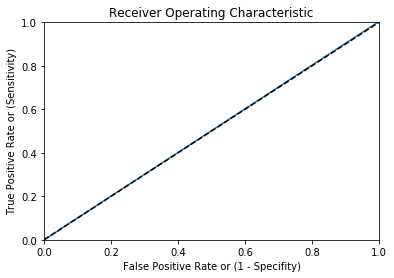

In [42]:
evaluate_on_training_set(valid_y, get_tag_flat(0.4))
#print(valid_y)